In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/banfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/banfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https

In [5]:
!pip install BnLemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.4 MB/s eta 0:00:00


In [6]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [7]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [8]:
df['data'] = df['headline'] + ' ' + df['content']

In [9]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [10]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [11]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [13]:
#for column in df.columns:
#    df[column] = df[column].str.slice(0, 100)

In [14]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [15]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0      1105      4
1      1735      4
2      1270      4
3      1698      4
4      1774      4
...     ...    ...
10387   481      4
10388  1824      4
10389  1592      4
10390  6848      4
10391  1229      4

[10392 rows x 2 columns]


In [16]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)


In [17]:
import BnLemma as lm
bl = lm.Lemmatizer()

for i in range(0,df.shape[0]):
    words = str(df['data'][i])
    df['data'][i] = bl.lemma(words)

In [18]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [20]:
pip install ktrain


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 44.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 43.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=98fbcefd14

In [21]:

import ktrain
from ktrain import text
MODEL_NAME = 'sagorsarker/bangla-bert-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [22]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 321
	95percentile : 784
	99percentile : 1333


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 314
	95percentile : 765
	99percentile : 1322


In [23]:
model = t.get_classifier()

In [24]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [25]:
history = learner.fit_onecycle(2e-5, 8)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/8
1386/1386 [==============================] - 696s 487ms/step - loss: 0.2271 - accuracy: 0.9129 - val_loss: 0.1687 - val_accuracy: 0.9461
Epoch 2/8
1386/1386 [==============================] - 671s 484ms/step - loss: 0.1179 - accuracy: 0.9537 - val_loss: 0.0943 - val_accuracy: 0.9673
Epoch 3/8
1386/1386 [==============================] - 671s 484ms/step - loss: 0.0682 - accuracy: 0.9750 - val_loss: 0.1646 - val_accuracy: 0.9562
Epoch 4/8
1386/1386 [==============================] - 710s 512ms/step - loss: 0.0444 - accuracy: 0.9853 - val_loss: 0.1464 - val_accuracy: 0.9639
Epoch 5/8
1386/1386 [==============================] - 671s 484ms/step - loss: 0.0296 - accuracy: 0.9909 - val_loss: 0.1377 - val_accuracy: 0.9668
Epoch 6/8
1386/1386 [==============================] - 671s 484ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.1615 - val_accuracy: 0.9711
Epoch 7/8
1386/1386 [==============================] - 

In [26]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 46s 668ms/step
              precision    recall  f1-score   support

        fake       0.88      0.88      0.88       248
        true       0.98      0.98      0.98      1831

    accuracy                           0.97      2079
   macro avg       0.93      0.93      0.93      2079
weighted avg       0.97      0.97      0.97      2079



array([[ 218,   30],
       [  30, 1801]])

In [27]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

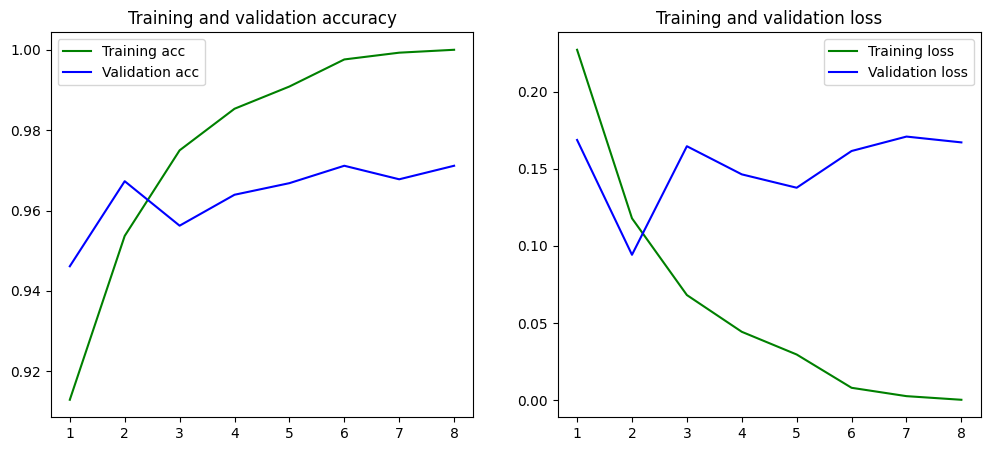

In [28]:
PlotGraph(history)